In [ ]:
!unzip /content/drive/MyDrive/MECH-NOISE-VL/TRAINNING.zip

# **Import Dependence**

In [ ]:
import numpy as np
import math


import os
import shutil
import glob

import librosa
import soundfile
from IPython.display import Audio, display


import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Lambda, Dense, Flatten, MaxPooling1D,Dropout, Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean, CosineSimilarity
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy

# **SOUND EMBEDED**

In [ ]:
def sound_emb(sound_file_dir):
    samples, sample_rate = librosa.load(sound_file_dir, sr=44100)
    samples = samples[int(sample_rate*0.1):int(sample_rate*0.3)]
    samples_emb = np.expand_dims(samples, axis=-1)
    del samples
    return samples_emb

# **CREATE TRIPLETS**

In [ ]:
def get_triplets(DATASET, max_triplets=3):
    if not os.path.isdir(DATASET):
        raise "DATASET PATH ERROR"

    positive_folder = os.path.join(DATASET, "OK")
    negative_folder = os.path.join(DATASET, "NG")
    pos_sounds = [os.path.join(positive_folder, sound_file) for sound_file in os.listdir(positive_folder)]
    neg_sounds = [os.path.join(negative_folder, sound_file) for sound_file in os.listdir(negative_folder)]

    del positive_folder, negative_folder

    triplets = []
    for _ in tqdm(range(len(pos_sounds)*max_triplets)):
        anchor_sound_triplets = random.sample(pos_sounds, 3)
        non_anchor_sound_triplets = [sound for sound in pos_sounds if sound not in anchor_sound_triplets]
        positive_sound_triplets = random.sample(non_anchor_sound_triplets, 3)
        negative_sound_triplets = random.sample(neg_sounds, 3)

        samples = [(anch, pos, neg) for anch, pos, neg in zip(anchor_sound_triplets, positive_sound_triplets, negative_sound_triplets)]
        triplets.extend(samples)
        del anchor_sound_triplets, non_anchor_sound_triplets, \
        positive_sound_triplets, negative_sound_triplets, samples
    triplets = list(set(triplets))

    del pos_sounds, neg_sounds
    return triplets

In [ ]:
DATASET = "DATASET/TRAIN"
triplets = get_triplets(DATASET)

DATASET = "DATASET/TEST"
test_triplets = get_triplets(DATASET)

100%|██████████| 2508/2508 [00:00<00:00, 12227.48it/s]


# **TRAIN & VAL SPLIT TRIPLETS**

In [ ]:
def split_triplets(triplets):
    train_triplets, val_triplets = train_test_split(triplets, test_size=0.3, shuffle=True, random_state=1234)
    return train_triplets, val_triplets

In [ ]:
train_triplets, val_triplets = split_triplets(triplets)
del triplets
len(train_triplets), len(val_triplets), len(test_triplets)

(12310, 5276, 7524)

# **BATCH GENERATOR & VISUALIZE**

## **BATCH GENERATOR**

In [ ]:
def batch_generator(triplets, batch_size=2048):
    """
    CREATE A BATCH OF TRIPLETS FOR SAVING MEMORY
    """
    total_triplets = len(triplets)
    random.shuffle(triplets)

    for i in range(0, total_triplets, batch_size):
        batch_triplets = triplets[i:i + batch_size]

        anchor_batch = np.array([sound_emb(triplet[0]) for triplet in batch_triplets])
        positive_batch = np.array([sound_emb(triplet[1]) for triplet in batch_triplets])
        negative_batch = np.array([sound_emb(triplet[2]) for triplet in batch_triplets])

        yield [anchor_batch, positive_batch, negative_batch]

## **VISUALIZING & PLAYING**

In [ ]:
def play_sound(audio):
    audio = np.reshape(audio, newshape=(8820,))
    audio_widget = Audio(audio, rate=44100)
    display(audio_widget)

def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    for i in range(len(anchor_batch)):
        play_sound(anchor_batch[i])
        play_sound(positive_batch[i])
        play_sound(negative_batch[i])

        print()
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.title("Anchor")
        plt.plot(anchor_batch[i])

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        plt.plot(positive_batch[i])

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        plt.plot(negative_batch[i])

        plt.show()
        print('\n', '\n')

CPU times: user 7.79 s, sys: 228 ms, total: 8.01 s
Wall time: 9.76 s


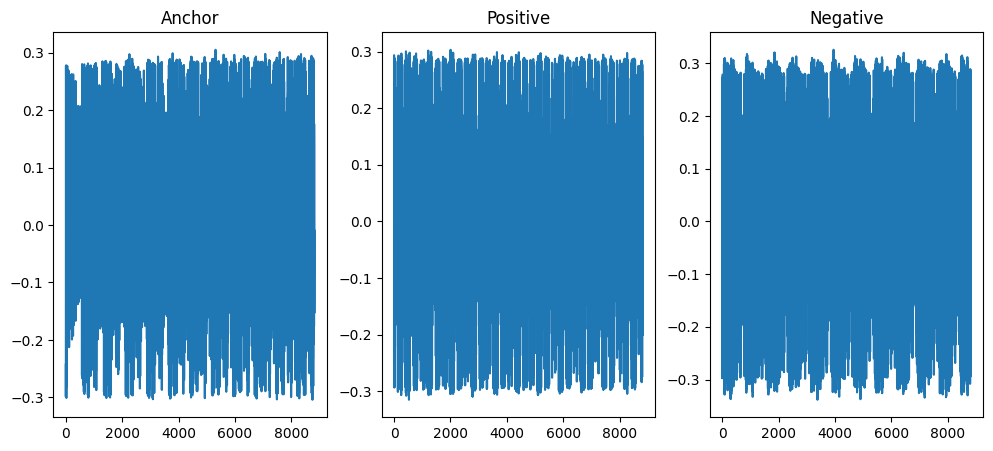

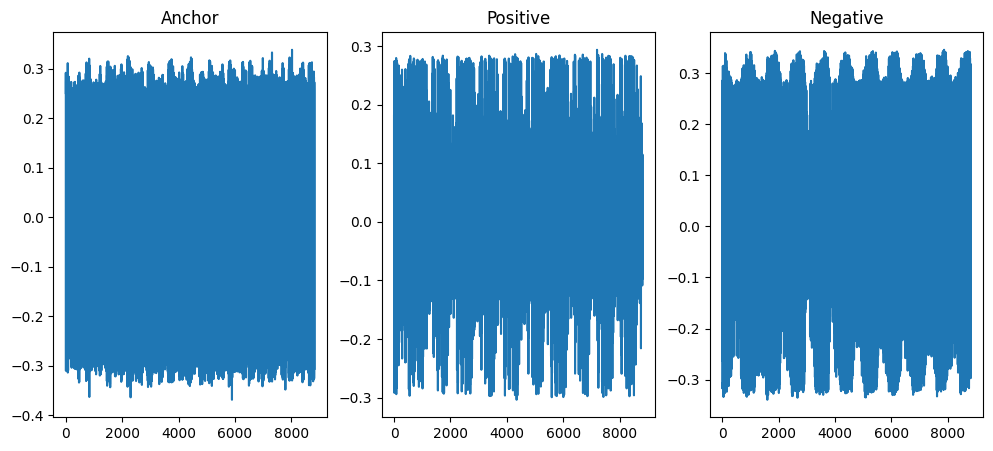

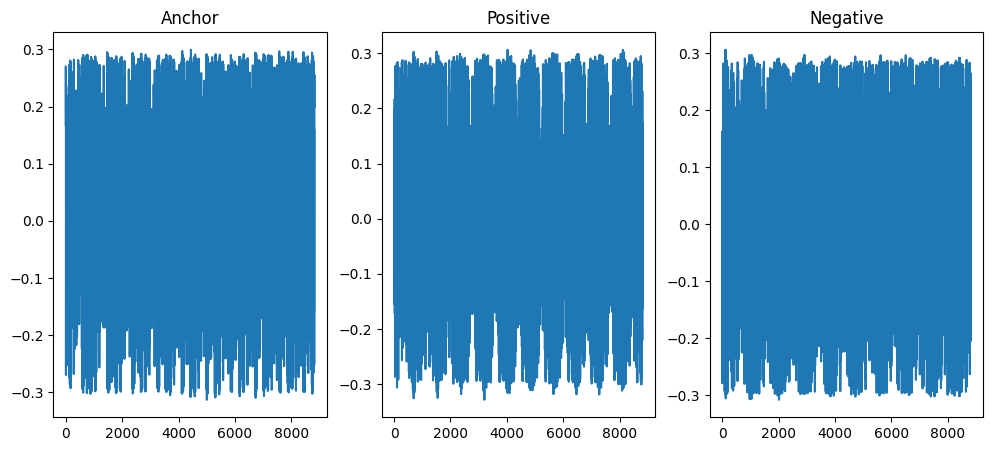

In [ ]:
%time example_triplets = [next(batch_generator(train_triplets, 3))]
visualize_triplets(example_triplets[0])

# **MODEL CONTRUCTION**

## **WDCNN**

In [ ]:
def WDCNN(input_shape =(8820,1)):

    model = Sequential(name='WDCNN')

    # WDCNN
    model.add(Conv1D(filters=16, kernel_size=32,
                     strides=16, activation='relu',
                     padding='same',input_shape=input_shape))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling1D(strides=2))
    model.add(Flatten())
    model.add(Dense(100, activation='sigmoid', name='embedding')) #sigmoid
    return model

## **DISTANCE LAYER**

In [ ]:
@tf.keras.utils.register_keras_serializable()
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

## **SIAMESE NET**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 8820, 1)]            0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 8820, 1)]            0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 8820, 1)]            0         []                            
                                                                                                  
 WDCNN (Sequential)          (None, 100)                  133460    ['anchor[0][0]',              
                                                                     'positive[0][0]',      

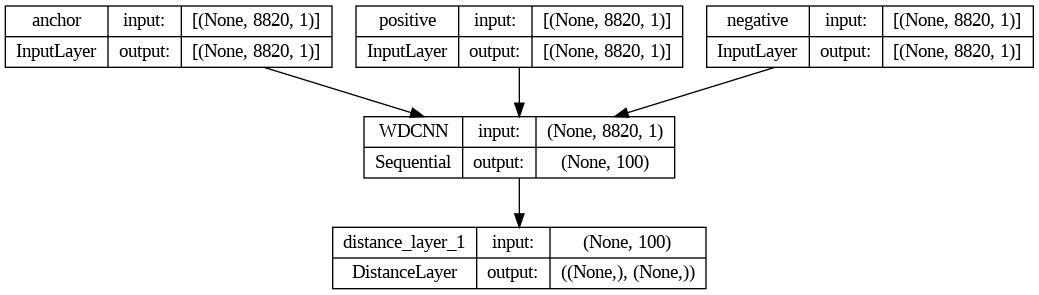

In [ ]:
input_shape = (8820, 1)

anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

embedding = WDCNN()
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)

print(siamese_net.summary())
print()

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

# **TRAIN STEP**

## **CONFIG**

### **DISTANCE COMPUTING**

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)


### **DISTANCE OPTIMIZER**

In [ ]:
def train_model(model,
                train_triplets,
                epochs,
                batch_size,
                val_triplets,
                patience,
                delta=0.0001): #0.0001

    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history

## **MODEL TRAINING**

In [ ]:
siamese_model = SiameseModel(siamese_net, margin=5)
siamese_model.compile(optimizer=Adam(0.01)) #0.001

siamese_model, history = train_model(siamese_model,
                                     train_triplets=train_triplets,
                                     epochs=50,
                                     batch_size=2048,
                                     val_triplets=val_triplets,
                                     patience=5)

Epoch 1/50


Validation: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it, Loss=5.03, Accuracy=0.596]



Train Loss: 4.5076, Train Accuracy: 0.7175
Validation Loss: 5.0163, Validation Accuracy: 0.5920

Epoch 2/50


Validation: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it, Loss=5, Accuracy=0.526]



Train Loss: 5.0003, Train Accuracy: 0.5371
Validation Loss: 4.9997, Validation Accuracy: 0.5299

Epoch 3/50


Validation: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it, Loss=5, Accuracy=0]



Train Loss: 5.0000, Train Accuracy: 0.1947
Validation Loss: 5.0000, Validation Accuracy: 0.0000

Epoch 4/50


Training:  43%|████▎     | 3/7 [00:09<00:12,  3.09s/it, Loss=5, Accuracy=0]

## **VISUALIZE TRAINING PROCESS**

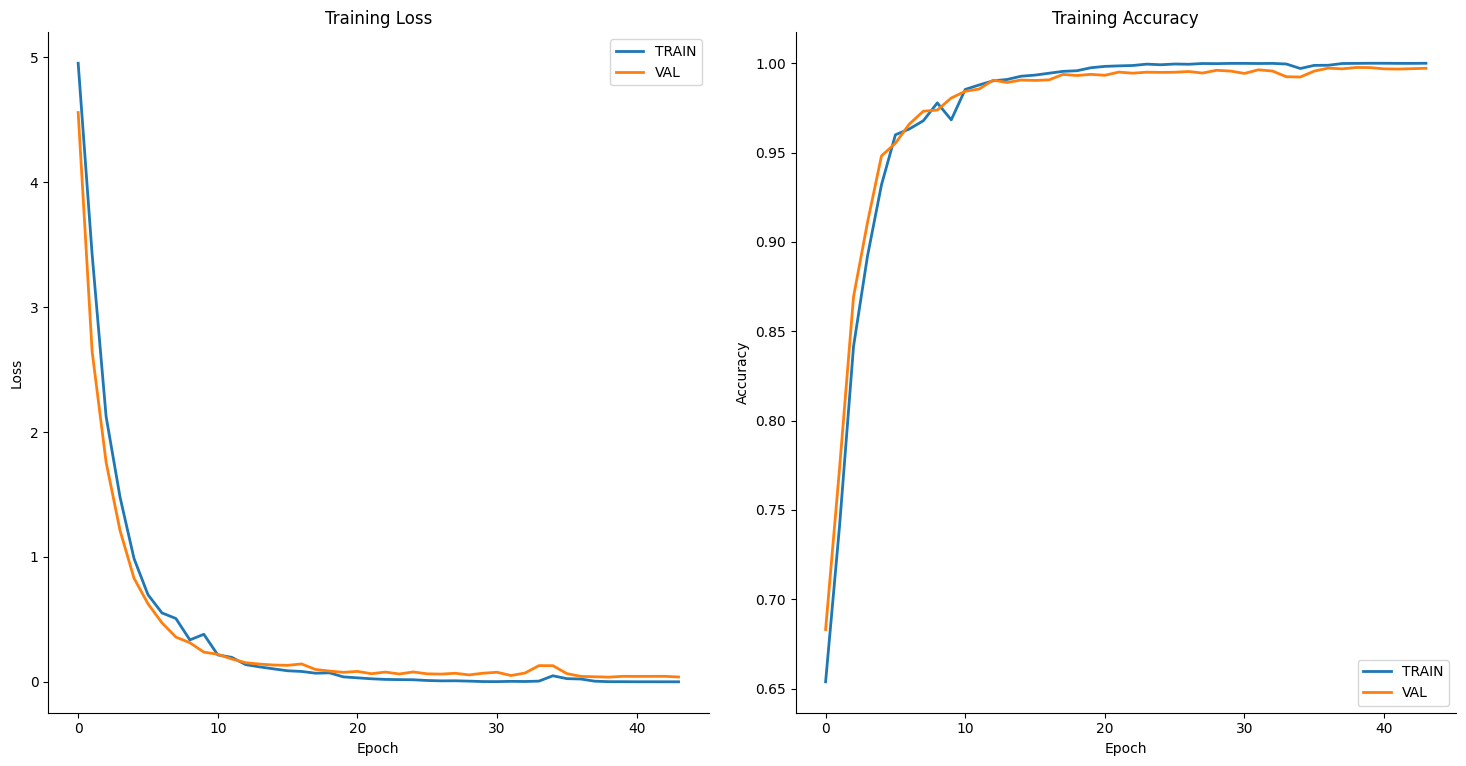

In [ ]:
def training_history_visualize(train_history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))


    sns.lineplot(data=train_history, x=range(len(train_history['loss'])), y=train_history['loss'],
                ax=axes[0], label='TRAIN', color='tab:blue', linewidth=2)

    sns.lineplot(data=train_history, x=range(len(train_history['val_loss'])),
                y=train_history['val_loss'], ax=axes[0], label='VAL', color='tab:orange', linewidth=2)
    axes[0].set_title('Training Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='upper right')


    sns.lineplot(data=train_history, x=range(len(train_history['accuracy'])), y=train_history['accuracy'],
                ax=axes[1], label='TRAIN', color='tab:blue', linewidth=2)
    sns.lineplot(data=train_history, x=range(len(train_history['val_accuracy'])),
                y=train_history['val_accuracy'], ax=axes[1], label='VAL', color='tab:orange', linewidth=2)
    axes[1].set_title('Training Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    sns.set(style="whitegrid")
    sns.despine()
    sns.set_context("notebook", font_scale=1.5)


    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 10
    plt.rcParams['lines.color'] = 'white'


    plt.tight_layout()
    plt.show()
    plt.close()


training_history_visualize(history)

# **TRAINING RESULT**

## **DISTANCE BY MODEL**

In [ ]:
sample = next(batch_generator(val_triplets, 1))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative)
)
dis_pos, dis_neg = siamese_model.predict([anchor, positive, negative])
print(f"Distance by model:\nPositive: {dis_pos[0]}, Negative: {dis_neg[0]}")
for s in sample:
    play_sound(s)


1/1 [==============================] - 0s 338ms/step
Distance by model:
Positive: 1.0665053129196167, Negative: 943.7451171875


## **DISTANCE DISTRIBUTION VISUALIZE**

In [ ]:
def distance_distribution_visualize(triplets, batch_size, type_name, threshold=None):
    num_triplets = len(triplets)
    num_batches = (num_triplets + batch_size - 1) // batch_size

    dis_pos_batch = []
    dis_neg_batch = []

    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_triplets)
        mini_batch_triplets = triplets[int(start_idx):int(end_idx)]
        anchors = [sound_emb(triplet[0]) for triplet in mini_batch_triplets]
        positives = [sound_emb(triplet[1]) for triplet in mini_batch_triplets]
        negatives = [sound_emb(triplet[2]) for triplet in mini_batch_triplets]

        anchor_batch = np.array(anchors)
        positive_batch = np.array(positives)
        negative_batch = np.array(negatives)
        del anchors, positives, negatives

        batch_dis_pos, batch_dis_neg = siamese_model.predict(
                    [anchor_batch, positive_batch, negative_batch],
                    verbose=0
            )

        del anchor_batch, positive_batch, negative_batch
        dis_pos_batch.extend(batch_dis_pos)
        dis_neg_batch.extend(batch_dis_neg)
        del batch_dis_pos, batch_dis_neg

    dis_pos_batch = np.array(dis_pos_batch)
    dis_neg_batch = np.array(dis_neg_batch)
    bin_edges = np.histogram_bin_edges(dis_neg_batch, bins='auto')
    fig = plt.figure(figsize=(15,10))
    axes = fig.subplot_mosaic("""AB
                                CC
                                """)

    plt.title('Distribution of Distance')
    plt.xlabel(f'Distance of {type_name.title()} set')
    plt.ylabel('Number of samples')

    sns.histplot(dis_pos_batch, bins=10,
                 kde=True, label="Anchor & Positive - OK",
                 ax=axes["A"], color='blue');

    axes["A"].legend(loc='upper right')

    sns.histplot(dis_neg_batch, bins=10,
                 kde=True, label="Anchor & Negative - NG",
                 ax=axes["B"], color='red');

    axes["B"].legend(loc='upper right')

    sns.histplot(dis_pos_batch, bins=10,
                 kde=True, label="Anchor & Positive - OK",
                 ax=axes["C"],  color='blue')

    sns.histplot(dis_neg_batch, bins=10,
                 kde=True, label="Anchor & Negative - NG",
                 ax=axes["C"],  color='red')

    axes["C"].legend(loc='upper right')

    if threshold is not None:
        axes["A"].axvline(x=threshold, color='r', linestyle='--')
        axes["B"].axvline(x=threshold, color='r', linestyle='--')
        axes["C"].axvline(x=threshold, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()
    return dis_pos_batch, dis_neg_batch


100%|██████████| 49/49 [00:18<00:00,  2.61it/s]


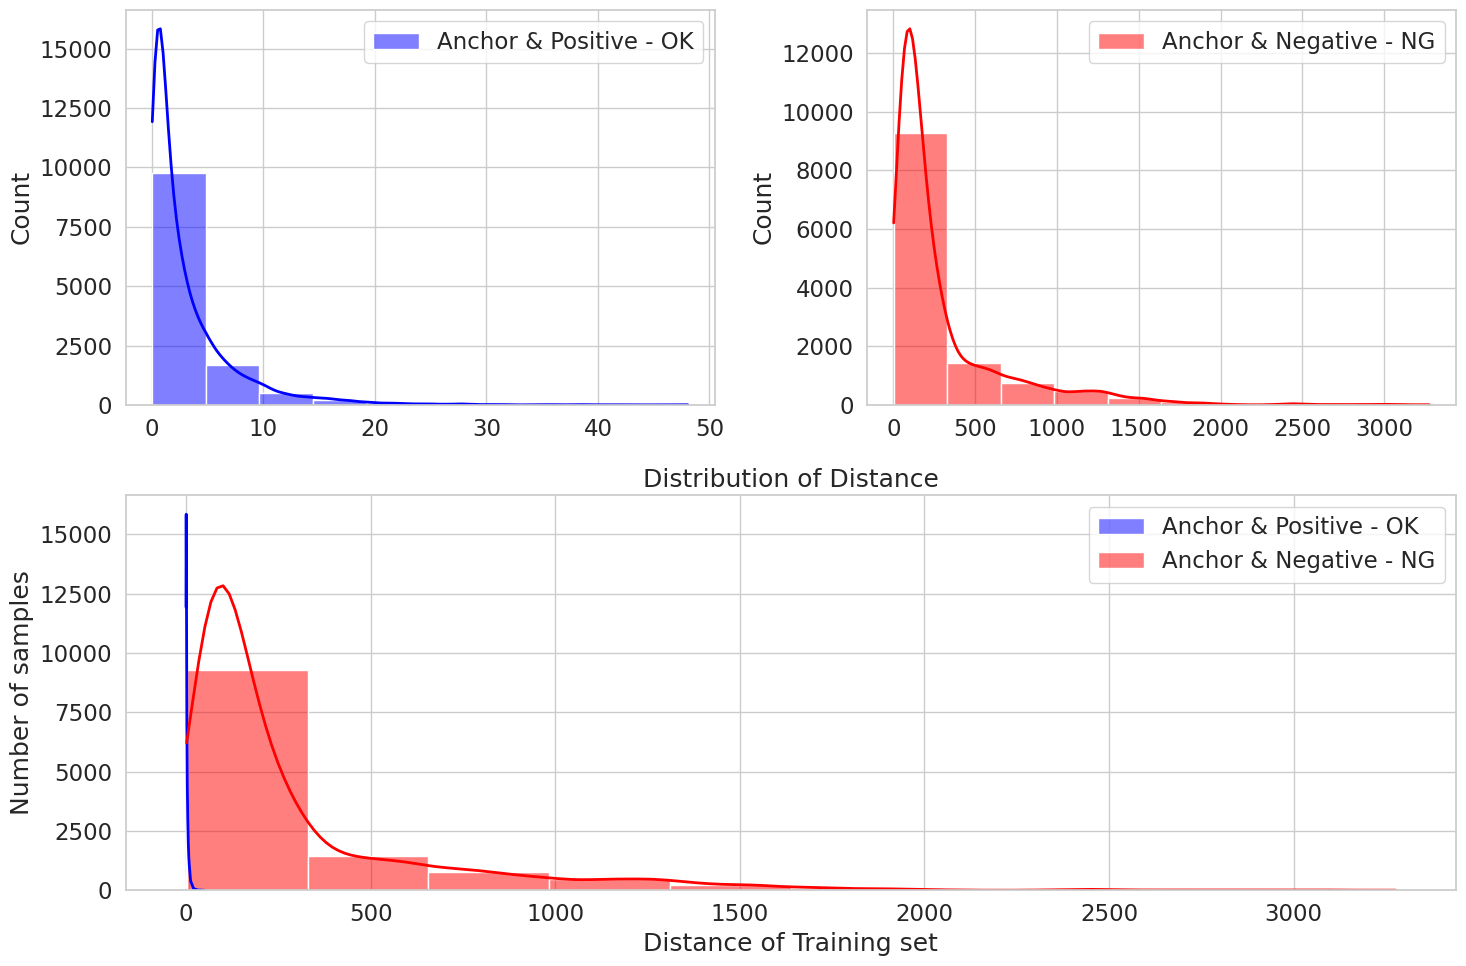

CPU times: user 18.7 s, sys: 2.32 s, total: 21.1 s
Wall time: 20.3 s


In [ ]:
%time train_dis_pos, train_dis_neg = distance_distribution_visualize(triplets=train_triplets, batch_size=256, type_name='Training')

100%|██████████| 21/21 [00:08<00:00,  2.55it/s]


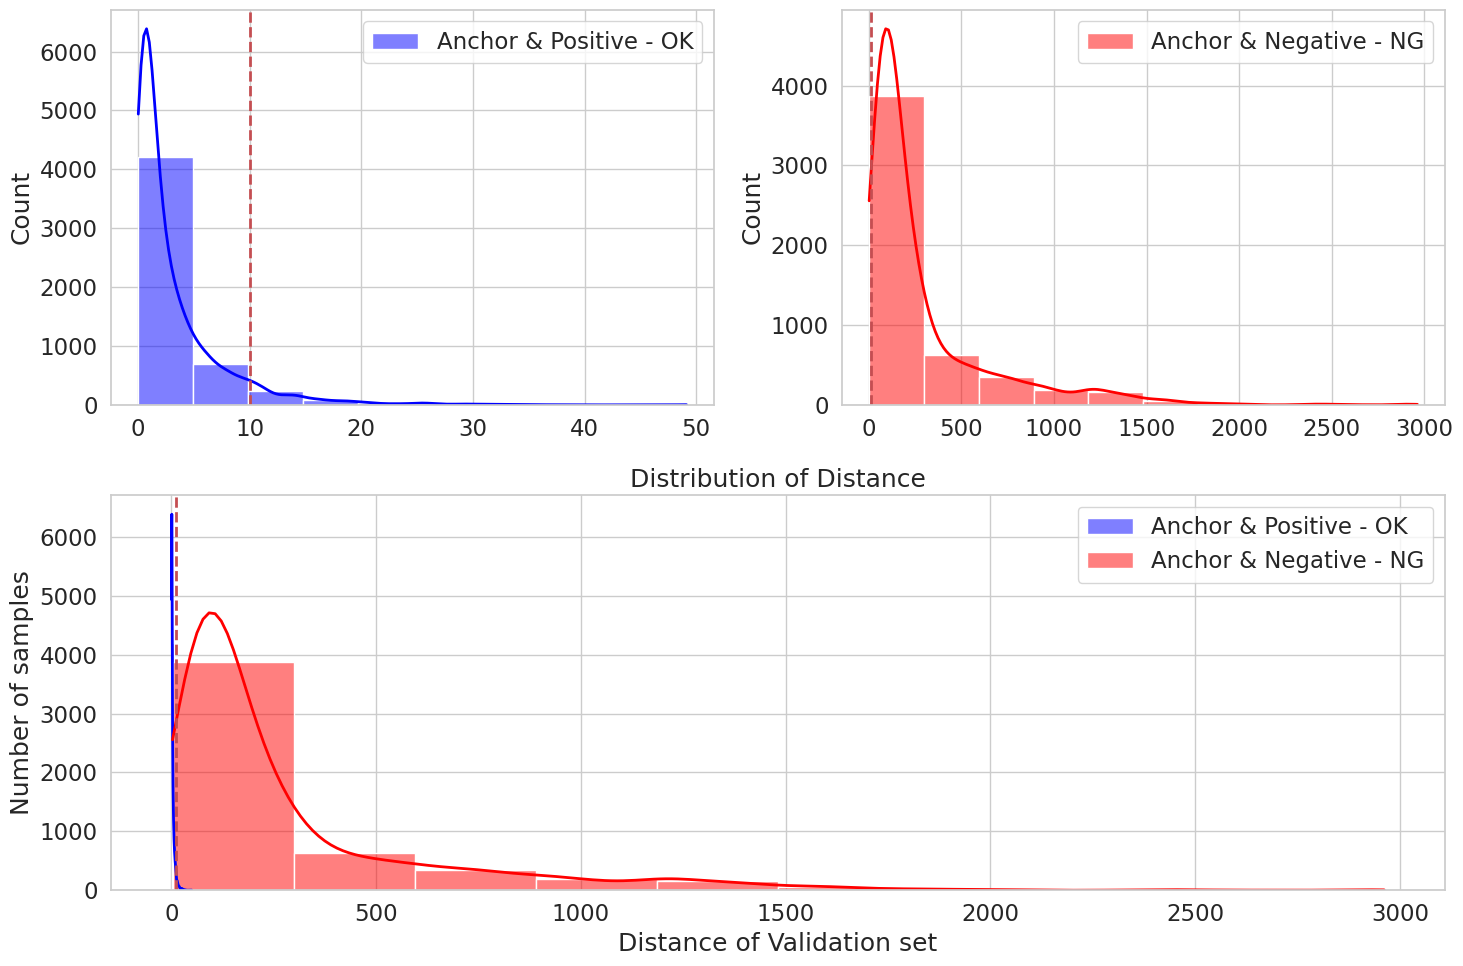

CPU times: user 9.18 s, sys: 1.08 s, total: 10.3 s
Wall time: 10 s


In [ ]:
%time val_dis_pos, val_dis_neg = distance_distribution_visualize(val_triplets, batch_size=256, type_name='Validation', threshold=10)

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      5276
         1.0       1.00      0.93      0.96      5276

    accuracy                           0.96     10552
   macro avg       0.97      0.96      0.96     10552
weighted avg       0.97      0.96      0.96     10552




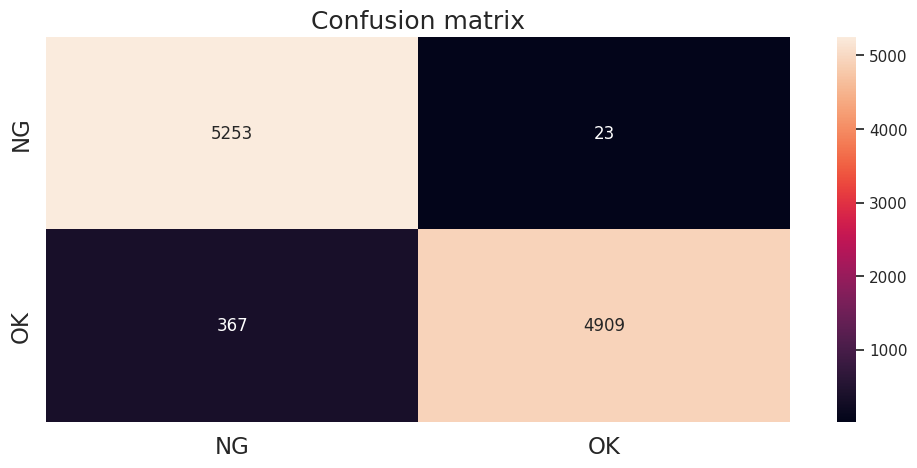

In [ ]:
confusion_matrix_test(val_dis_pos, val_dis_neg)

# **TESTING MODEL RESULT**

## **DIST DISTRIBUTION & THRESHOLD**

100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


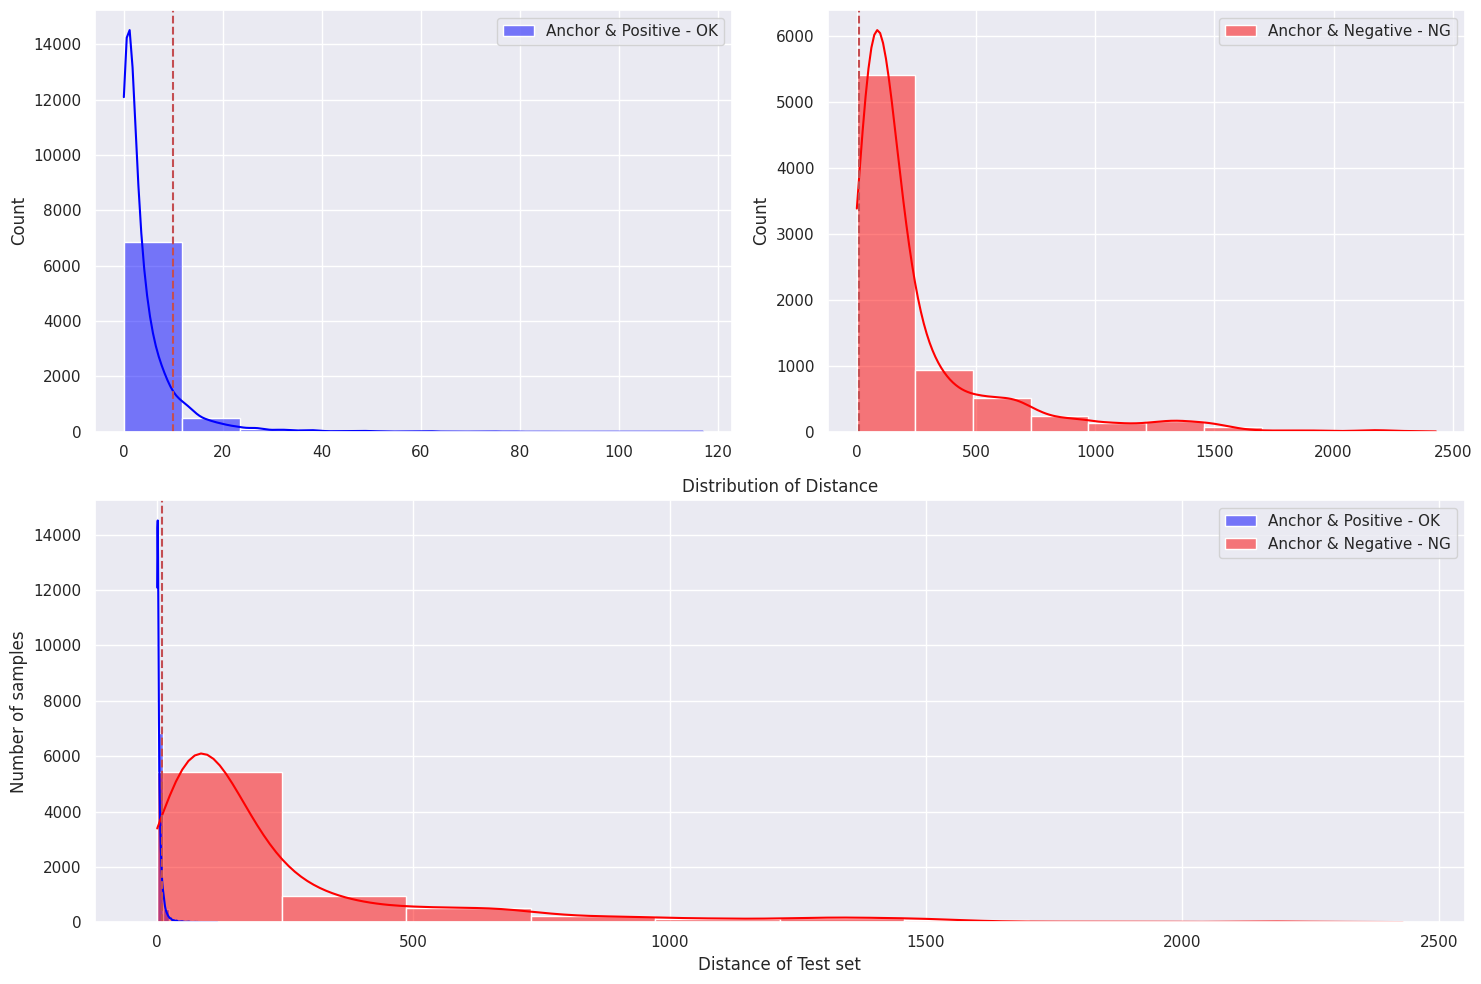

CPU times: user 12.5 s, sys: 1.51 s, total: 14 s
Wall time: 13.5 s


In [ ]:
%time test_dis_pos, test_dis_neg = distance_distribution_visualize(test_triplets, batch_size=256, type_name='Test', threshold=10)

## **CONFUSION MATRIX AND ACCURACY ON TEST**

In [ ]:
def confusion_matrix_test(dis_pos, dis_neg, threshold=10, class_label = {0: "NG", 1: "OK"}):
    correct_pos = sum(distance <= threshold for distance in dis_pos)
    correct_neg = sum(distance >= threshold for distance in dis_neg)

    predicted = np.array([1 if distance <= threshold else 0 for distance in dis_pos] + [0 if distance >= threshold else 1 for distance in dis_neg])
    ground_truth = np.concatenate((np.ones_like(dis_pos), np.zeros_like(dis_neg)))

    plt.figure(figsize=(12, 5))
    cf_matrix3 = confusion_matrix(ground_truth, predicted)
    plt.title("Confusion matrix")
    sns.set(rc={'figure.figsize': (12, 6)})
    sns.heatmap(cf_matrix3, annot=True, fmt="d",
                xticklabels=class_label.values(),
                yticklabels=class_label.values())

    print(classification_report(ground_truth, predicted))
    print()
    plt.show()

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.93      7524
         1.0       0.97      0.89      0.93      7524

    accuracy                           0.93     15048
   macro avg       0.93      0.93      0.93     15048
weighted avg       0.93      0.93      0.93     15048




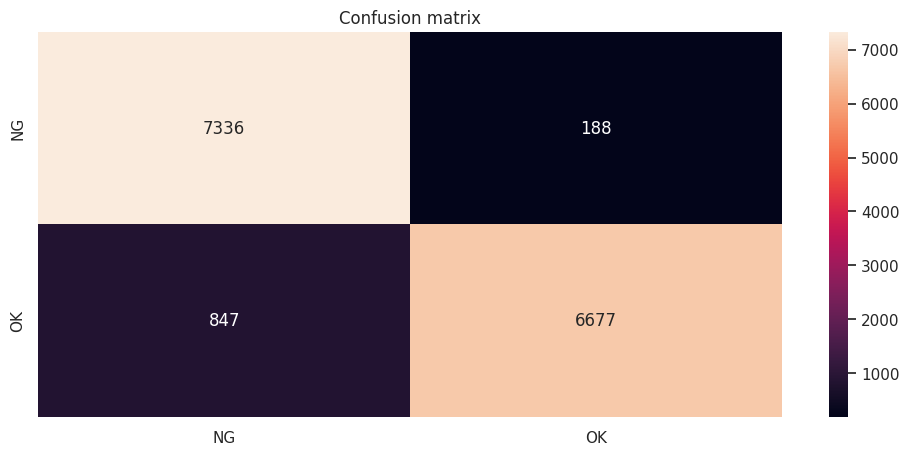

In [ ]:
confusion_matrix_test(test_dis_pos, test_dis_neg)

# **MODEL INFERENCE**